In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import torchvision
from torchvision import datasets, models, transforms

In [2]:
def calculating_loss(net, X, y, batch_size, loss_fn, optimizer, train_model=False):
  """
  Calculating loss for given parameters.
  Has option to train model(if train_model=True)
  """
  X, y = shuffle(X, y)

  for k in range(0, len(y), BATCH_SIZE):
    X_batch = X[k:k+BATCH_SIZE].to(device)
    y_batch = y[k:k+BATCH_SIZE].to(device)
    
    if train_model:
      net.train()
      outputs = net(X_batch.view(-1, 1, 224, 224).float())
      loss = loss_fn(outputs, y_batch.float())
      net.zero_grad()
      loss.backward()
      optimizer.step()    
    else:
      with torch.no_grad():
        net.eval()
        outputs = net(X_batch.view(-1, 1, 224, 224))
        loss = loss_fn(outputs, y_batch.float())

  loss = float(loss)
  loss = np.round(loss, 2)

  return loss

def calculating_acc(net, X, y):
  """
  Calculating accuracy for given network and data.
  """
  correct = 0
  total = 0

  with torch.no_grad():
    for i in range(len(y)):
      label = int(torch.argmax(y[i]))
      X_inner = X[i].to(device)
      output = net(X_inner.view(1, 1, 224, 224).float())
      pred = int(torch.argmax(output))
      
      if pred==label:
        correct += 1

      total += 1

  acc = correct / total * 100
  acc = np.round(acc, 2)

  return acc

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
from google.colab import drive
drive.mount("/content/drive")

X = np.load('/content/drive/My Drive/Notebooks/X_data(224x224, gray).npy', allow_pickle=True).astype(np.float32)
y = np.load('/content/drive/My Drive/Notebooks/y_data(224x224, gray).npy', allow_pickle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
X = X / 255.
X = X.astype(np.float32)

In [6]:
preprocess = transforms.Normalize(mean=[0.449], std=[0.22])

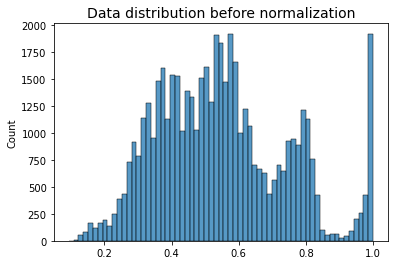

In [7]:
a = X[0].flatten()
sns.histplot(a)
plt.title('Data distribution before normalization', fontsize = 14)
plt.show()

In [8]:
X_train = torch.tensor(X[:20000]).view(-1, 1, 224, 224)
y_train = torch.tensor(y[:20000])

X_test = torch.tensor(X[20000:]).view(-1, 1, 224, 224)
y_test = torch.tensor(y[20000:])

del X, y

In [9]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

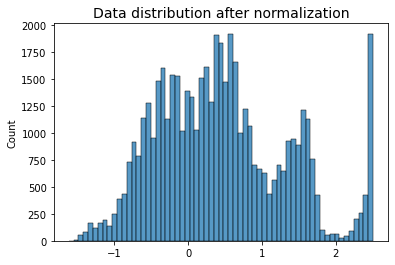

In [10]:
a = X_train[0].flatten()
sns.histplot(a)
plt.title('Data distribution after normalization', fontsize=14)
plt.show()

### Model

In [11]:
vgg19 = models.vgg16_bn(pretrained=True)

for param in vgg19.parameters():
  param.requires_grad = False


vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
cls = nn.Sequential(nn.Linear(25088, 1024),
                       nn.ReLU(inplace=True),
                       nn.Dropout(p=0.5, inplace=False),
                       nn.Linear(1024, 2),
                       nn.Softmax(1)
                       )

vgg19.classifier = cls

vgg19.to(device)
print('')

In [12]:
EPOCHS = np.arange(1)
BATCH_SIZE = 64
LR = 0.0001
WD = 0.003
loss_fn = nn.BCELoss()
optimizer = optim.Adam(vgg19.parameters(), lr =LR, weight_decay=WD)

train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []

for epoch in tqdm(EPOCHS):

  train_loss = calculating_loss(vgg19, X_train, y_train, BATCH_SIZE, loss_fn, optimizer, train_model=True)
  train_loss_array.append(train_loss)

  test_loss = calculating_loss(vgg19, X_test, y_test, BATCH_SIZE, loss_fn, optimizer, train_model=False)
  test_loss_array.append(test_loss)

  train_acc = calculating_acc(vgg19, X_train, y_train)
  train_acc_array.append(train_acc)

  test_acc = calculating_acc(vgg19, X_test, y_test)
  test_acc_array.append(test_acc)

In [20]:
print('Train loss: ', train_loss_array)
print('Test loss: ', test_loss_array)

Previous>
Train loss:  [0.12]
Test loss:  [0.13]


In [21]:
print('Train Acc: ', train_acc_array)
print('Test Acc: ', test_acc_array)

Previous>
Train Acc:  [96.04]
Test Acc:  [93.05]
